In [119]:
import matplotlib.pyplot as plt
from ase.io import read,write
import numpy as np
from ase import Atoms
from abtem import *
from abtem.scan import GridScan
import time
import glob
import os


In [141]:
os.system('rm POSCAR*')

256

In [144]:
os.system('unzip raw_data/POSCAR_RHEA.zip')

256

In [145]:
files = glob.glob('POSCAR_*K*')

In [146]:
for file in files:
    os.rename(file, file+'_Zaxis100')

## to generate a box with c-vector [1,1,0]
the original box has a c vector [1,0,0]

the new box: a-vector: [0,0,1], b-vector[1,-1,0], c-vector[1,1,0]


In [147]:
def generate_110_box(atoms):
    
    cell_old = atoms.get_cell()
    atoms = atoms.repeat((1,2,2))
    cell = atoms.get_cell()
    center = (0,cell[1,1]*0.5,cell[2,2]*0.5)
    atoms.rotate(45,'x', center)

    width = cell_old[1,1]
    thickness = cell_old[2,2]
    mask = (atoms.positions[:,1] <= center[1]+width/2.)   & \
           (atoms.positions[:,1] >  center[1] - width/2.) & \
           (atoms.positions[:,2] <= center[2]+thickness/2.)   & \
           (atoms.positions[:,2] > center[2] - thickness/2.) 
    atoms = atoms[mask]
    positions = atoms.get_positions()
    positions[:,1] = positions[:,1] - np.mean(positions[:,1]) + width/2.
    positions[:,2] = positions[:,2] - np.mean(positions[:,2]) + thickness/2.
    atoms.set_positions(positions)
    cell_0 = atoms.get_cell()[0,0]
    atoms.set_cell((cell_0,width, thickness),scale_atoms=False)
    return atoms

In [149]:
files = glob.glob('POSCAR_*K*')
for file in files:
    atoms = read(file)
    _, temperature, index, axis = file.split('_')
    atoms = generate_110_box(atoms)
    write('POSCAR_'+temperature+'_'+index+'_Zaxis110',atoms,format='vasp')


## Hyperparameters

In [169]:
interpolation = 6

## Frozen phonon
Here I simply used a sigma of 0.1 Angstrom.
If MTP potential works well, we may take snapshots from thermostat MD directly.

In [170]:
def job_writer(filename):
    job_filename = 'job_'+filename
    python_filename = filename + '.py'
    outf = open(job_filename, 'w')
    outf.write("#!/bin/bash -l\n")
    outf.write("# Standard output and error:\n")
    outf.write("#SBATCH -o ./tjob_hybrid.out.%j\n")
    outf.write("#SBATCH -e ./tjob_hybrid.err.%j\n")
    outf.write("# Initial working directory:\n")
    outf.write("#SBATCH -D ./\n")
    outf.write("# Job Name:\n")
    outf.write("#SBATCH -J {}\n".format(filename))
    outf.write("# Queue (Partition):\n")
    outf.write("#SBATCH --partition=p.talos\n")
    outf.write("# Number of nodes and MPI tasks per node:\n")
    outf.write("#SBATCH --nodes=1\n")
    outf.write("#SBATCH --ntasks-per-node=20\n")    
    outf.write("# for GPU\n")
    outf.write("#SBATCH --gres=gpu:1\n")
    outf.write("#SBATCH --mail-type=none\n")
    outf.write("#SBATCH --mail-user=nwang@mpie.de\n")
    outf.write("# Wall clock limit:\n")
    outf.write("#SBATCH --time=96:00:00\n")
    outf.write("\nconda activate abtem\n\n")
    outf.write("# Run the program:\n")
    outf.write("python {}".format(python_filename))
    outf.close()    

In [171]:
def python_script_writer(filename='run',
                         poscar_file='POSCAR',
                         interpolation=8):
    python_filename = filename + '.py'
    output_filename = filename + '.hdf5'
    outf = open(python_filename, 'w')
    outf.write("from ase.io import read\n")
    outf.write("from abtem import *\n")
    outf.write("from abtem.scan import GridScan\n")
    outf.write("import time\n")
    outf.write("atoms = read('{}',format='vasp')\n".format(poscar_file))
    
    outf.write("sigma = 0.1\n")
    outf.write("frozen_phonons = FrozenPhonons(atoms, num_configs=12, sigmas=[sigma,]*len(atoms), seed=1001)\n")
    outf.write("potential = Potential(frozen_phonons,slice_thickness=0.5, sampling=0.024, device='cpu')\n")
    outf.write("cell = atoms.get_cell()\n")
    outf.write("interpolation = %d\n" % (interpolation,))
    outf.write("S = SMatrix(expansion_cutoff=28,\n")
    outf.write("            interpolation=interpolation,\n")
    outf.write("            energy=300e3,\n")
    outf.write("            semiangle_cutoff=24,\n")
    outf.write("            defocus=0,\n")
    outf.write("            focal_spread=60,\n")
    outf.write("             device='gpu',\n")
    outf.write("             storage='cpu')\n")
    outf.write("detector = AnnularDetector(inner=95, outer=200, save_file='{}')\n".format(output_filename))
    outf.write("gridscan = GridScan(start=[0, 0], end=[cell[0,0], cell[1,1]], sampling=0.125)\n")
    outf.write("start_time = time.time()\n")
    outf.write("measurements = S.scan(gridscan, [detector], potential)\n")
    outf.write("time_cost = time.time() - start_time\n")
    outf.write("out_time = open('time_cost.dat','a')\n")
    filename, _ = python_filename.split('.')
    outf.write("out_time.write('{}: %8.2f [s]\\n' % (time_cost,))\n".format(filename))
    outf.write("out_time.close()\n")
    outf.close()

## Generate job scripts and python scripts and submit jobs

In [172]:
files = glob.glob('POSCAR_*K*')
for file in files:
    _, temperature, index, axis = file.split('_')    
    filename = temperature + '_' + index
    filename = '{}_interp_{}_'.format(axis,interpolation)+filename
    python_script_writer(filename=filename,
                         poscar_file = file,
                         interpolation=interpolation)
    job_writer(filename)
    job_filename = 'job_'+filename
    os.system('sbatch {}'.format(job_filename))

## A quick test in jupyter notebook

In [23]:
atoms = read('POSCAR_1520K_2',format='vasp')
sigma = 0.1
frozen_phonons = FrozenPhonons(atoms, n_configs = 12,[sigma,]*len(atoms), seed=1)
potential = Potential(frozen_phonons,slice_thickness=0.5, sampling=0.024, device='cpu')
cell = atoms.get_cell()
interpolation = 8
S = SMatrix(expansion_cutoff=28,
            interpolation=interpolation,
            energy=300e3,
            semiangle_cutoff=24,
            defocus=0,
            focal_spread=60,
            device='gpu',
            storage='cpu')

detector = AnnularDetector(inner=95, outer=200, save_file='prism_interpolation_6.hdf5')
gridscan = GridScan(start=[0, 0], end=[cell[0,0], cell[1,1]], sampling=0.125)
start_time = time.time()
measurements = S.scan(gridscan, [detector], potential)
print ('time cost: %8.2f' % (time.time()-start_time,))

In [25]:
start_time = time.time()
measurements = S.scan(gridscan, [detector], potential)
print ('time cost: %8.2f' % (time.time()-start_time,))




time cost:   408.17


In [26]:
from abtem.measure import Measurement
measurement = Measurement.read('prism_interpolation_6.hdf5')

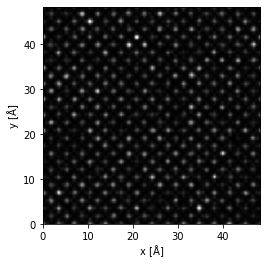

In [27]:
measurement.show();